# RL for power grid management using Grid2Op

## Set up google collab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

working_path  = 'gdrive/MyDrive/Colab Notebooks/rl-project/'

%cd 'gdrive/MyDrive/Colab Notebooks/rl-project/'

import sys
sys.path.append(working_path)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/rl-project


In [2]:
!pip install grid2op gymnasium stable_baselines3 sb3_contrib numba lightsim2grid tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 60.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 858.4/858.4 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for pandapower: filename=pandapower-2.14.11-py3-none-any.whl size=13131028 sha256=5debf85d9ae657ab7d22478ab8ec1f6f5307411c6ea454005145e9c181380007
  Stored in directory: /root/.cache/pip/wheels/7f/de/5a/7b00f385eb06d1fb1f7c1cd06f9bb901709c038d3899548cf1
Successfully built pandapower


#### Imports

In [3]:
import numpy as np
import grid2op
import matplotlib.pyplot as plt
import glob
import os
import json

# Local files
from utils import fpath, read_episode_data, read_episodes
from env_wrapper import Grid2opEnvWrapper
from agent_wrapper import Grid2opAgentWrapper

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


# 1. Create the environnement

The training, validation and test sets are already split.

In [4]:
base_path = os.path.expanduser('/root/data_grid2op') #Google Collab

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
env_name =  "l2rpn_case14_sandbox" # Name of the environment
env_file = "env_config.json" # Configuration of the environment

train_dir = os.path.join(base_path, f"{env_name}_train/")
val_dir = os.path.join(base_path, f"{env_name}_val/")
test_dir = os.path.join(base_path, f"{env_name}_test/")

def directories_exist(train_path, val_path, test_path):
    return os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path)

# Make environment
env = grid2op.make(env_name)

if directories_exist(train_dir, val_dir, test_dir):
    print("Directories already exist. Skipping train-val-test split.")
else:
    print("Directories do not exist. Proceeding with train-val-test split.")
    # Perform the split
    try:
        nm_env_train, nm_env_val, nm_env_test = env.train_val_split_random(
            pct_val=10, # 10% validation
            pct_test=10, # 10% test
            add_for_train="train",
            add_for_val="val",
            add_for_test="test"
        )
        print(f"Training environment created: {nm_env_train}")
        print(f"Validation environment created: {nm_env_val}")
        print(f"Test environment created: {nm_env_test}")
    except OSError as e:
        print(f"An error occurred during splitting: {e}")

/usr/local/lib/python3.10/dist-packages/grid2op/MakeEnv/Make.py:506: UserWarning: It is the first time you use the environment "l2rpn_case14_sandbox".
We will attempt to download this environment from remote
  warnings.warn(_MAKE_FIRST_TIME_WARN.format(dataset_name))


downloading the training data, this may take a while.


l2rpn_case14_sandbox.tar.bz2: 294MB [00:49, 5.95MB/s]                           


Extract the tar archive in "/root/data_grid2op"
	 Successfully updated file "config.py" for environment "l2rpn_case14_sandbox"
	 Successfully updated file "grid.json" for environment "l2rpn_case14_sandbox"
You may now use the environment "l2rpn_case14_sandbox" with the available data by invoking:
	env = grid2op.make("l2rpn_case14_sandbox")
Directories do not exist. Proceeding with train-val-test split.
Training environment created: l2rpn_case14_sandbox_train
Validation environment created: l2rpn_case14_sandbox_val
Test environment created: l2rpn_case14_sandbox_test


In [6]:
from grid2op.Reward import L2RPNReward

# Load the JSON file
with open(env_file, "r") as file:
    env_config = json.load(file)
env_config["reward_class"] = L2RPNReward

# Training environnement
train_env_config = env_config.copy()
train_env_config["data_set"] = "train"
train_env = Grid2opEnvWrapper(train_env_config)

# Validation environnement
val_env_config = env_config.copy()
val_env_config["data_set"] = "val"
val_env = Grid2opEnvWrapper(val_env_config)

# Test environnement
test_env_config = env_config.copy()
test_env_config["data_set"] = "test"
test_env = Grid2opEnvWrapper(test_env_config)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.2 Visualising the grid

Here, we visualize the state of the grid.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


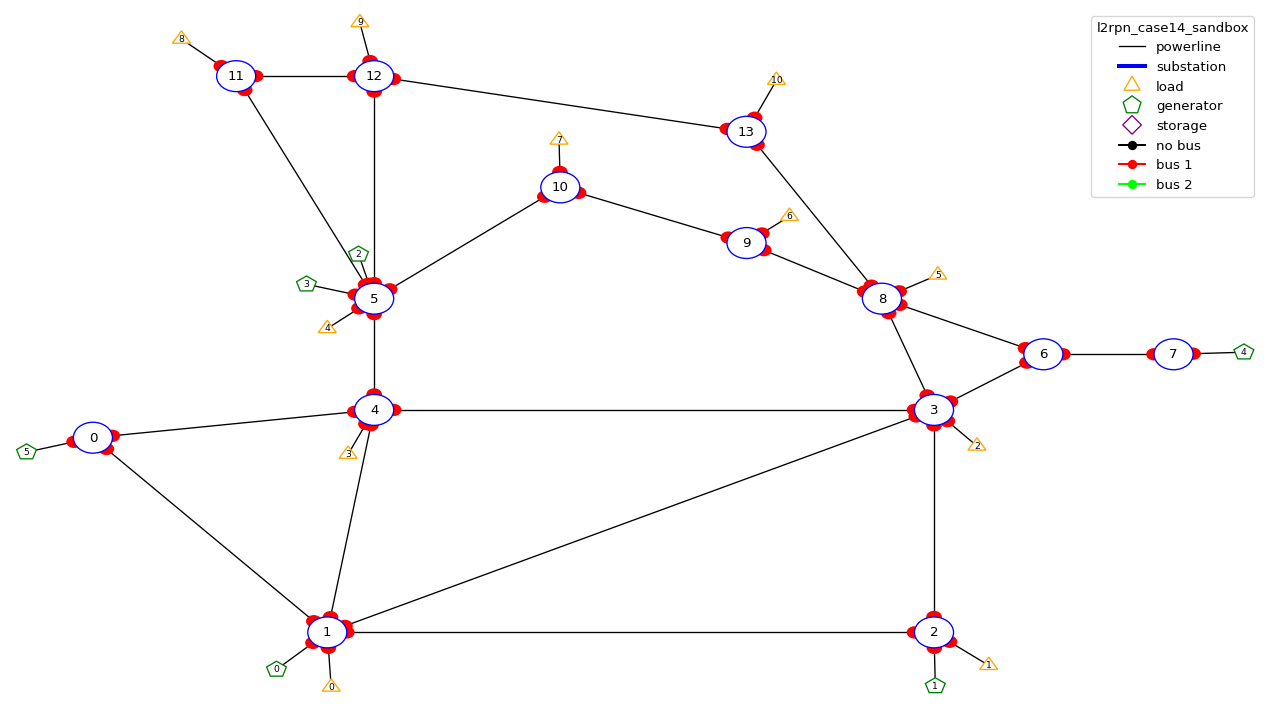

In [7]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_layout()

# 2. Training a model OR Loading a pre-trained model

In this section you have the choice to train the model or load a pre-trained model.

In [8]:
from stable_baselines3 import A2C
algo = A2C #The winning agent
result_path = 'results'

### 2.1 Load pre-trained Model
Comment this section if using the training model!

In [9]:
agent_path = 'pretrained'

### 2.2 Training an agent
Uncomment this section for training (takes around an hour). Leave it commented to load the pre-trained model.

The training is monitored in Tensorboard.

In [10]:
# %load_ext tensorboard
# %tensorboard --logdir='tensorboard_logs'

In [11]:
# from stable_baselines3.common.callbacks import EvalCallback
# from stable_baselines3.common.monitor import Monitor

# ######## TRAINING PARAMETERS ####################
# N_TIMESTEP = 1_000_000
# N_EVAL_EPISODES= 5
# EVAL_FREQ = 30_000
# ################################################

# agent_path = 'not_pre_trained'

# monitor_env = Monitor(val_env, filename='./monitor_log', allow_early_resets=True)
# log_dir = "./tensorboard_logs/"

# # Define the model path and tensorboard log name
# model_name, model_path, tb_log_name = fpath(algo,agent_path)

# # Create Call back:
# eval_callback = EvalCallback(
#     eval_env=monitor_env,
#     n_eval_episodes=N_EVAL_EPISODES,
#     eval_freq=EVAL_FREQ,
#     log_path = model_path,
#     best_model_save_path=model_path,
#     deterministic=True,
#     render=False,
#     verbose=0 )


# # Initialize the algorithm
# policy = "MlpPolicy"

# sb3_algo = algo(
#     policy,
#     train_env,
#     verbose=0,
#     tensorboard_log=log_dir,
# )

# # Train the model
# sb3_algo.learn(
#     total_timesteps=N_TIMESTEP,
#     tb_log_name=tb_log_name,
#     callback=eval_callback
# )

# # Save the model
# sb3_algo.save(model_path+'/'+model_name)

# print(f"{model_name} model saved at {model_path}")

# 3. Compare to baseline agents

In this section, we evaluate the performance of our agent and of 2 baseline agents (Random policy and Do Nothing poly) on 20 scenarios from the test set.

In [12]:
from grid2op.Runner import Runner
from grid2op.Agent import DoNothingAgent, RandomAgent


# Testing parameters ##########################################################
nb_episode_test = 20
seeds_test_env = tuple(range(nb_episode_test))  # Seeds for the environment
seeds_test_agent = tuple(range(nb_episode_test))  # Seeds for the agent
ts_ep_test = tuple(range(nb_episode_test))
###############################################################################

# Trained agents
model_name, model_path, _ =  fpath(algo,agent_path)

# Load the trained model
sb3_algo_to_test = algo.load(model_path+'/'+model_name, env=test_env)

# Convert to grid2op agent
my_agent = Grid2opAgentWrapper(test_env, sb3_algo_to_test)

runner = Runner(**test_env._g2op_env.get_params_for_runner(),
                agentClass=None,
                agentInstance=my_agent)

res = runner.run(nb_episode=nb_episode_test,
                env_seeds=seeds_test_env,
                agent_seeds=seeds_test_agent,
                # episode_id=ts_ep_test,
                add_detailed_output=True,
                path_save=result_path +'/' + agent_path + '_' + model_name
                )

# Baseline agents:
baseline_agents= [RandomAgent, DoNothingAgent]
for baseline_agent in baseline_agents :

    model_name, model_path, _ =  fpath(baseline_agent,agent_path)

    runner = Runner(**test_env._g2op_env.get_params_for_runner(),
                agentClass=baseline_agent)

    res = runner.run(nb_episode=nb_episode_test,
                 env_seeds=seeds_test_env,
                 agent_seeds=seeds_test_agent,
                #  episode_id=ts_ep_test,
                 add_detailed_output=True,
                 path_save=result_path +'/' + model_name
                 )

#### 3.1 Results

Here, we look at the 3 metrics: (1) the cumulative reward per episode, (2) the percentage of the episode that the agent managed to survive and (3) if the agent managed to complete the whole scenario.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


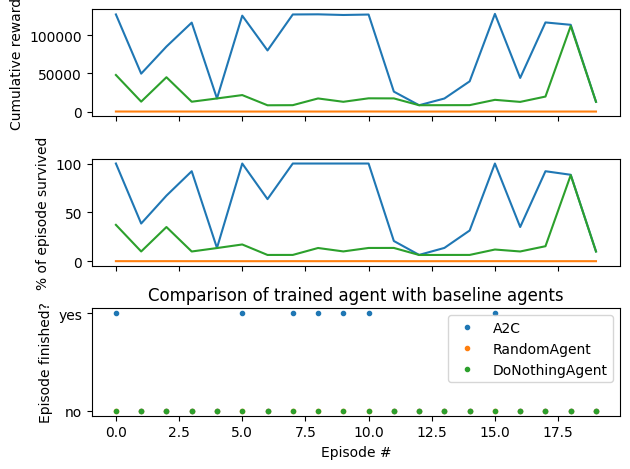

In [13]:
import matplotlib.pyplot as plt
import glob

fig, ax = plt.subplots(3,1,sharex=True)
plt.title('Comparison of trained agent with baseline agents')
ax[2].set_xlabel('Episode #')
ax[0].set_ylabel('Cumulative reward')
ax[1].set_ylabel('% of episode survived')
ax[2].set_ylabel('Episode finished?')

# Trained agent
model_name = algo.__name__
files = glob.glob(result_path +'/' + agent_path + '_' + model_name + '/*/episode_meta.json')
n_ep=np.arange(len(files))
rewards, survived, percentage, finished = read_episodes(files)

ax[0].plot(n_ep, rewards, '-',label=model_name)
ax[1].plot(n_ep, percentage, '-',label=model_name)
ax[2].plot(n_ep, finished, '.', label=model_name)
ax[2].legend()

# Baseline agents
for baseline_agent in baseline_agents :
    model_name = baseline_agent.__name__
    files = glob.glob(result_path +'/' + model_name + '/*/episode_meta.json')
    n_ep=np.arange(len(files))
    rewards, survived, percentage, finished = read_episodes(files)

    ax[0].plot(rewards, '-',label=model_name)
    ax[1].plot(n_ep, percentage, '-',label=model_name)
    ax[2].plot(n_ep, finished, '.', label=model_name)
ax[2].set_yticks([0, 1])  # Same for y-axis
ax[2].set_yticklabels(['no', 'yes'])
ax[2].legend()
plt.tight_layout()
plt.show()